# Define the Model

In [1]:
# load librispeech dataset
!wget https://www.openslr.org/resources/12/dev-clean.tar.gz -P ./data/train/
!tar -xf ./data/train/dev-clean.tar.gz -C ./data/train/

--2024-10-29 19:50:33--  https://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/dev-clean.tar.gz [following]
--2024-10-29 19:50:34--  https://openslr.elda.org/resources/12/dev-clean.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘./data/train/dev-clean.tar.gz’

dev-clean.tar.gz    100%[===================>] 322.27M  36.5MB/s    in 9.6s    

2024-10-29 19:50:44 (33.7 MB/s) - ‘./data/train/dev-clean.tar.gz’ saved [337926286/337926286]



In [2]:
import os

# define data directory
data_dir = './data/train/LibriSpeech/dev-clean/84/121123/'
higher_data_dir = './data/train/LibriSpeech/dev-clean/'
all_files = []

# load audio files into memory
for dir1 in os.listdir(higher_data_dir):
    for dir2 in os.listdir(higher_data_dir + dir1):
        for f in os.listdir(higher_data_dir + dir1 + '/' + dir2):
            file_path = higher_data_dir + dir1 + '/' + dir2 + '/' + f
            if f.endswith('.flac'):
                all_files.append(file_path)

print(len(all_files))

2703


In [3]:
# Display a sample audio file
from IPython.display import Audio

display(Audio(all_files[0]))

# START AYUSH'S CODE

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa.display

In [5]:
def load_audio(file_path: str) -> np.ndarray:
    """
    Load an audio file and return its waveform as a numpy array.

    Parameters:
    file_path (str): Path to the audio file.

    Returns:
    np.ndarray: Audio waveform, and sample rate.
    """
    audio, sr = librosa.load(file_path, sr=16000)  # Load audio with original sampling rate
    return audio, sr

def extract_spectrogram(audio: np.ndarray, sr: int = 16000) -> np.ndarray:
    """
    Convert the audio waveform to a Mel spectrogram.

    Parameters:
    audio (np.ndarray): The audio waveform.
    sr (int): The sampling rate of the audio.

    Returns:
    np.ndarray: Spectrogram (magnitude in decibels).
    """
    # Extract Mel-spectrogram using librosa's correct method signature
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)

    # Convert to decibels (dB scale)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    # spectrogram_amp = librosa.db_to_amplitude(spectrogram)

    return spectrogram_db

def save_spectrogram(spectrogram: np.ndarray, file_path: str):
    """
    Save the spectrogram as a .npy file.

    Parameters:
    spectrogram (np.ndarray): The spectrogram to save.
    file_path (str): Path where to save the spectrogram file.
    """
    np.save(file_path, spectrogram)

In [6]:
def add_noise(audio: np.ndarray, noise_factor: float = 0.02) -> np.ndarray:
    """
    Adds random noise to an audio signal.

    Parameters:
    audio (np.ndarray): Input audio signal.
    noise_factor (float): Factor to scale the noise.

    Returns:
    np.ndarray: Noisy audio signal.
    """
    noise = np.random.randn(len(audio))
    noisy_audio = audio + noise_factor * noise

    # Clip the values to ensure they remain in the valid audio range (-1 to 1)
    noisy_audio = np.clip(noisy_audio, -1.0, 1.0)

    return noisy_audio

In [7]:
# Load clean audio
clean_audio, sr = load_audio(all_files[0])

# Add noise to the clean audio
noisy_audio = add_noise(clean_audio)

# Save the noisy audio as a new .flac file
sf.write('noisy_audio.flac', noisy_audio, sr, format='FLAC')

In [8]:
# Extract spectrogram for clean audio
clean_spectrogram = extract_spectrogram(clean_audio, sr)
clean_spectrogram.shape

# Extract spectrogram for noisy audio
noisy_spectrogram = extract_spectrogram(noisy_audio, sr)

In [9]:
# display clean audio
display(Audio(all_files[0]))

# display noisy audio
display(Audio('noisy_audio.flac'))

In [10]:
# Save the clean and noisy spectrograms
save_spectrogram(clean_spectrogram, "clean_spectrogram.npy")
save_spectrogram(noisy_spectrogram, "noisy_spectrogram.npy")

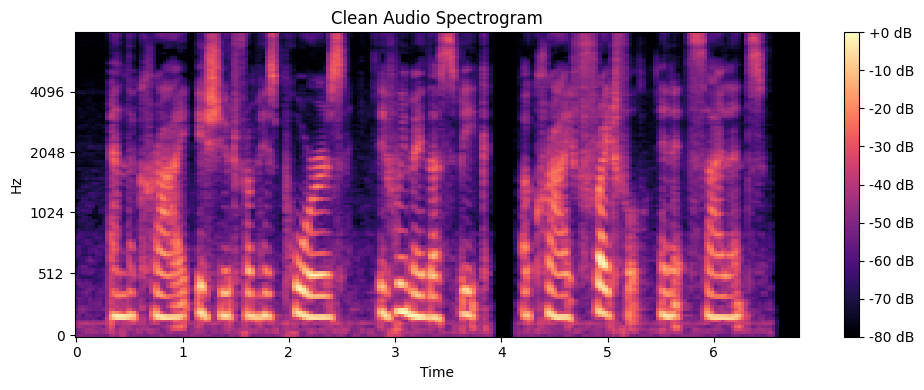

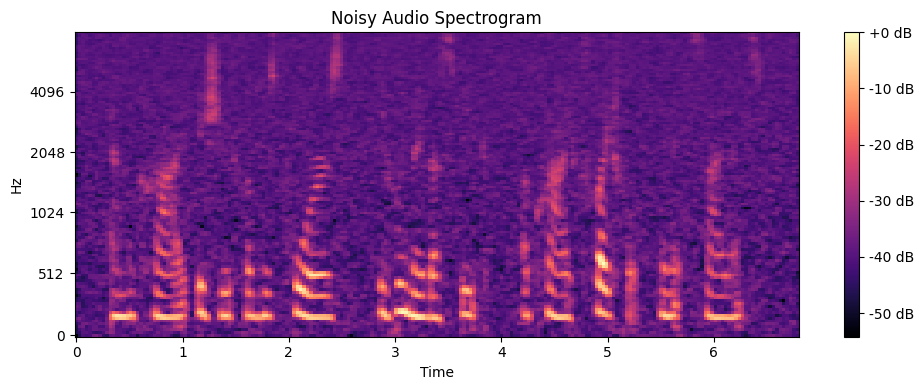

In [11]:
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot clean and noisy spectrograms
plot_spectrogram(clean_spectrogram, 'Clean Audio Spectrogram')
plot_spectrogram(noisy_spectrogram, 'Noisy Audio Spectrogram')

# END AYUSH'S CODE

In [12]:
clean_spectrogram.shape

(128, 213)

In [13]:
noisy_spectrogram.shape

(128, 213)

In [14]:
# Librispeech is sampled at 16kHz
# since audio files are of different lengths, we need to standardize the lengths
# we can do this by separating audio into chunks
# I chose 16000 samples by 1.02 seconds, as the output shape for the spectrogram
# is then (128, 32)

samplerate = 16000
window_duration = 1.02
window_samples = int(samplerate * window_duration)

clean_spectrograms = []
noisy_spectrograms = []

# for each window in each audio file, get and store the associated spectrogram
for flac_file in all_files:
    for start in range(0, len(clean_audio), window_samples):
        end = start + window_samples

        clean_window = clean_audio[start:end]
        noisy_window = noisy_audio[start:end]

        if len(clean_window) < window_samples:
            continue

        clean_spectrogram = extract_spectrogram(clean_window, sr)
        clean_spectrograms.append(clean_spectrogram)

        noisy_spectrogram = extract_spectrogram(noisy_window, sr)
        noisy_spectrograms.append(noisy_spectrogram)

In [15]:
len(clean_spectrograms)

16218

In [16]:
# turn list into numpy array
# since the model is expecting 3 channels, repeat the value 3 times
rgb_clean_spectrograms = np.repeat(np.array(clean_spectrograms)[..., np.newaxis], 3, axis=-1)
rgb_noisy_spectrograms = np.repeat(np.array(noisy_spectrograms)[..., np.newaxis], 3, axis=-1)

print(rgb_clean_spectrograms.shape)
print(rgb_noisy_spectrograms.shape)

(16218, 128, 32, 3)
(16218, 128, 32, 3)


In [17]:
# split train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(rgb_noisy_spectrograms, rgb_clean_spectrograms, test_size=0.1, random_state=42)

In [18]:
X_train.shape

(14596, 128, 32, 3)

In [19]:
# normalization so that each value in the spectrograms is within range of 0 and 1
min_val = -80
max_val = 0

scaled_X_train = (X_train - min_val) / (max_val - min_val)
scaled_X_test = (X_test - min_val) / (max_val - min_val)
scaled_y_train = (y_train - min_val) / (max_val - min_val)
scaled_y_test = (y_test - min_val) / (max_val - min_val)

In [20]:
print(np.min(scaled_X_train))
print(np.max(scaled_y_train))
print(np.min(scaled_X_test))
print(np.max(scaled_y_test))

0.36135005041909285
1.0
0.36135005041909285
1.0


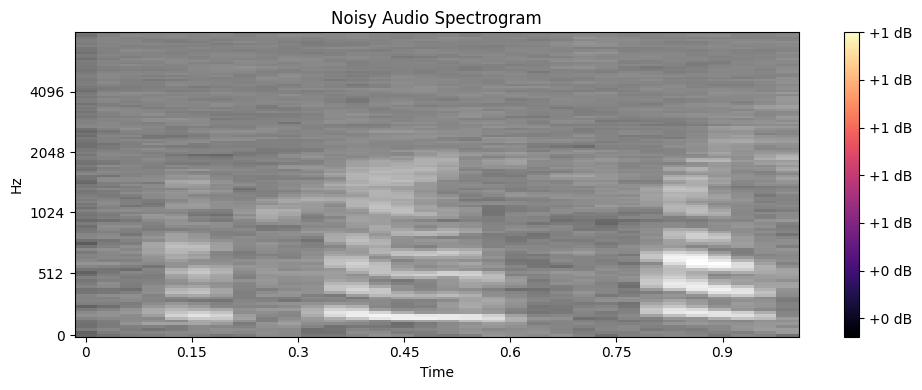

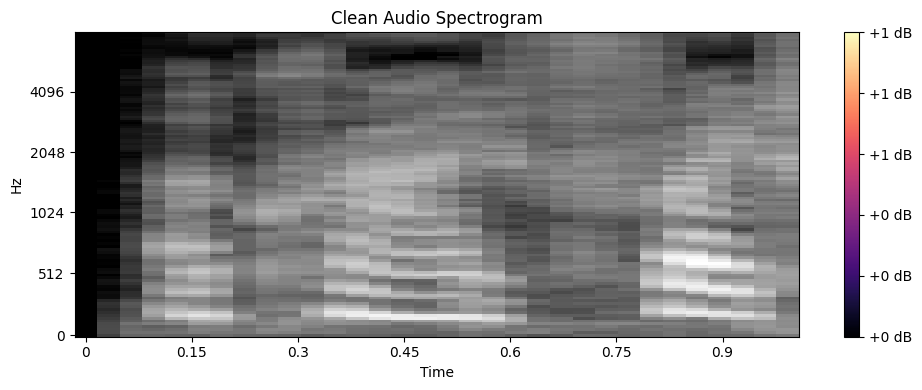

In [21]:
plot_spectrogram(scaled_X_train[0], 'Noisy Audio Spectrogram')
plot_spectrogram(scaled_y_train[0], 'Clean Audio Spectrogram')

In [22]:
# function to turn the spectrogram back into the audio signal
def inverse_spectrogram(spectrogram):
    mel_spectrogram = librosa.db_to_power(spectrogram)
    linear_spectrogram = librosa.feature.inverse.mel_to_stft(mel_spectrogram, sr=16000, n_fft=2048)
    audio_signal = librosa.griffinlim(linear_spectrogram, n_iter=64, hop_length=512, n_fft=2048)
    audio_signal *= 50
    return audio_signal

In [23]:
# turn the first clean_spectrogram back into audio
inversed = inverse_spectrogram(clean_spectrograms[0])

In [24]:
# play the audio
display(Audio(inversed, rate=16000))

In [25]:
from tensorflow import keras
from keras.applications import VGG16, ResNet50

# Load a pretrained model and return the model.
def load_pretrained_model(model_name: str) -> keras.Model:
  if model_name == 'vgg':
    return VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 32, 3)
    )
  elif model_name == 'resnet':
    return ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
  else:
    return None

model = load_pretrained_model('vgg')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Freeze the layers of a pretrained model to retain learned features.
# Return the model.
def freeze_layers(model: keras.Model) -> keras.Model:
  for layer in model.layers:
    layer.trainable = False
  return model

model = freeze_layers(model)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 32, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 32, 64)         │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 32, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 8, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 8, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 8, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 4, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 4, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 4, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 4, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
from keras.layers import Conv2D, UpSampling2D, BatchNormalization
from keras.models import Model

# Add custom layers to the pretrained model to turn it into an
# encoder-decoder architecture for audio denoising
def add_custom_layers(model: keras.Model) -> keras.Model:
  base_model = model

  # set the encoder to the pretrained model output
  encoder = model.output

  # Bottleneck - lower dimensional hidden layer where encoding is produced
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)
  x = BatchNormalization()(x)

  def decoder_layers(x: keras.Model, unit_size: int) -> keras.Model:
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(unit_size, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

  # Decoder - turn it back into a spectrogram
  x = decoder_layers(x, 256)
  x = decoder_layers(x, 128)
  x = decoder_layers(x, 64)
  x = decoder_layers(x, 32)
  x = decoder_layers(x, 16)

  outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  return Model(inputs=base_model.input, outputs=outputs)

full_model = add_custom_layers(model)
full_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 32, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 32, 64)         │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 32, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 8, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 8, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 8, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 4, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 4, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 4, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 4, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 4, 1, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 18,650,497 (71.15 MB)

 Trainable params: 3,933,793 (15.01 MB)

 Non-trainable params: 14,716,704 (56.14 MB)

In [28]:
# Compile the model using the given optimizer and loss function
def compile_model(loc_model: keras.Model, optimizer: str, loss_function: str):
  loc_model.compile(optimizer=optimizer, loss=loss_function, metrics=['mae'])

compile_model(full_model, 'rmsprop', 'mean_squared_error')

In [29]:
# Save the model to the given file path
def save_model(loc_model: keras.Model, file_path: str):
  loc_model.save(file_path)

save_model(full_model, "updated_model.keras")

In [30]:
full_model.fit(scaled_X_train, scaled_y_train, batch_size=64, epochs=50)

Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - loss: 0.0183 - mae: 0.0898
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0022 - mae: 0.0335
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0019 - mae: 0.0307
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0011 - mae: 0.0240
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 8.8604e-04 - mae: 0.0219
Epoch 6/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 7.9683e-04 - mae: 0.0206
Epoch 7/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 6.2400e-04 - mae: 0.0185
Epoch 8/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 6.2514e-04 - mae: 0.0185
Epoch 9/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 5.0753e-04 - mae: 0.0167
Epoch 10/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 5.3217e-04 - mae: 0.0169
Epoch 11/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 4.9246e-04 - mae: 0.0163
Epoch 12/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 4.317

In [31]:
save_model(full_model, "trained_model.keras")

In [32]:
predictions = full_model.predict(scaled_X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step


In [34]:
unscaled_predictions = predictions * (max_val - min_val) + min_val

test_inversed = inverse_spectrogram(np.squeeze(unscaled_predictions[0]))

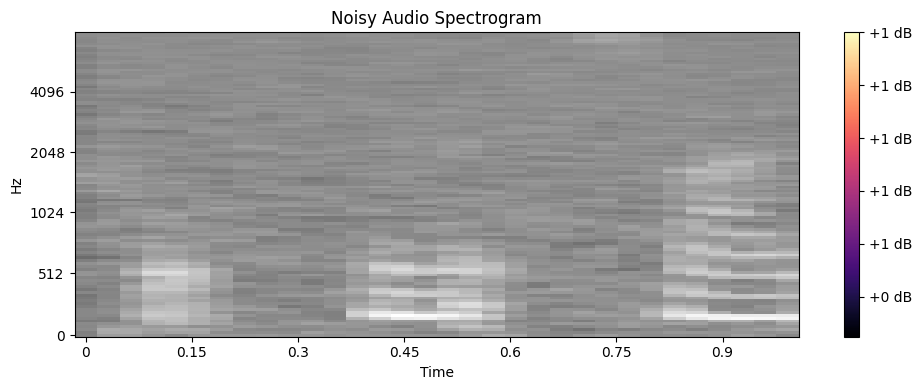

In [46]:
plot_spectrogram(scaled_X_test[1], 'Noisy Audio Spectrogram')

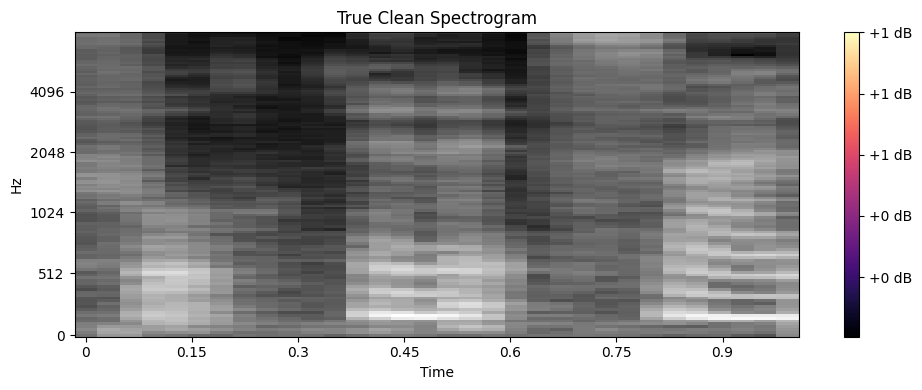

In [47]:
plot_spectrogram(scaled_y_test[1], 'True Clean Spectrogram')

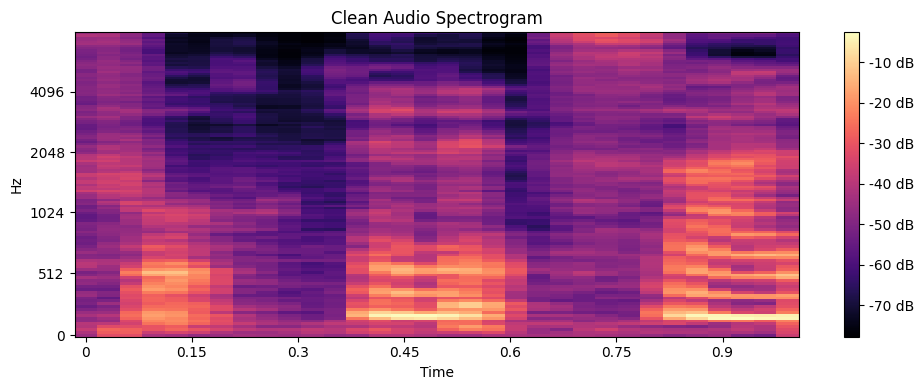

In [48]:
plot_spectrogram(np.squeeze(unscaled_predictions[1]), 'Clean Audio Spectrogram')

In [50]:
display(Audio(test_inversed, rate=16000))